# EDA and Feature Engineering

In [26]:
#!pip install gmplot
#!pip install geopandas
#!pip install descartes

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from datetime import datetime

import plotly.express as px
#import geopandas as gpd
#from shapely.geometry import Point, Polygon

from src import eda_feat_eng_utils

#import gmplot

### Slice Dataset to Desired Data Range

In [6]:
# accidents = pd.read_csv('data/chi_traffic_accidents.csv')

# start_date = datetime(2017, 9, 1)
# end_date = datetime(2020, 3, 1)
# accidents['crash_date'] = pd.to_datetime(accidents['CRASH_DATE'])
# accidents = accidents[(start_date <= accidents['crash_date']) & (accidents['crash_date'] < end_date)].copy()

# accidents.to_csv('data/chi_traffic_accidents_sub.csv')

### Import Revised Dataset

In [7]:
accidents = pd.read_csv('data/chi_traffic_accidents_sub.csv', parse_dates=['crash_date'], index_col=0)

In [8]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293075 entries, 0 to 472799
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH_RECORD_ID                293075 non-null  object        
 1   RD_NO                          293075 non-null  object        
 2   CRASH_DATE_EST_I               20235 non-null   object        
 3   CRASH_DATE                     293075 non-null  object        
 4   POSTED_SPEED_LIMIT             293075 non-null  int64         
 5   TRAFFIC_CONTROL_DEVICE         293075 non-null  object        
 6   DEVICE_CONDITION               293075 non-null  object        
 7   WEATHER_CONDITION              293075 non-null  object        
 8   LIGHTING_CONDITION             293075 non-null  object        
 9   FIRST_CRASH_TYPE               293075 non-null  object        
 10  TRAFFICWAY_TYPE                293075 non-null  object        
 11  

In [9]:
accidents.head(3)

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,crash_date
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,3.0,0.0,17,4,7,41.919664,-87.773288,POINT (-87.773287883007 41.919663832993),2019-07-10 17:56:00
5,00e47f189660cd8ba1e85fc63061bf1d8465184393f134...,JC194776,NaN,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,...,0.0,2.0,0.0,22,5,3,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989),2019-03-21 22:50:00
6,0126747fc9ffc0edc9a38abb83d80034f897db0f739eef...,JB200478,NaN,03/26/2018 02:23:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,2.0,0.0,14,2,3,41.953647,-87.732082,POINT (-87.732081736006 41.953646899951),2018-03-26 14:23:00


## UDF

### Feature Engineering

In [10]:
accidents['crash_year'] = accidents['crash_date'].dt.year
accidents['crash_month'] = accidents['crash_date'].dt.month
accidents['is_fatal'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'FATAL', 1, 0)
accidents['is_incap'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'INCAPACITATING INJURY', 1, 0)
accidents['is_fatal_or_incap'] = accidents['is_fatal'] + accidents['is_incap']



In [11]:
# Removed columsn because data is administrative or describes the resulting injuries.
cols_to_drop = ['CRASH_DATE_EST_I', 'CRASH_RECORD_ID', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I',
               'CRASH_RECORD_ID', 'is_fatal', 'is_incap', 'CRASH_MONTH', 'INJURIES_REPORTED_NOT_EVIDENT', 'DAMAGE', 'REPORT_TYPE',
               'DATE_POLICE_NOTIFIED', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_FATAL', 'INJURIES_TOTAL', 'INJURIES_INCAPACITATING',
               'INJURIES_NON_INCAPACITATING', 'INJURIES_NO_INDICATION']

accidents.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
# Date/time
accidents['time_of_day'] = accidents['CRASH_HOUR'].apply(lambda hr: eda_feat_eng_utils.time_of_day(hr))
accidents['is_weekend'] = accidents['CRASH_DAY_OF_WEEK'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, [1, 7]))
accidents['season'] = accidents['crash_month'].apply(lambda x: eda_feat_eng_utils.create_season_feature(x))

# Conlision related
accidents['involved_pedest_cycle'] = accidents['FIRST_CRASH_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['PEDALCYCLIST', 'PEDESTRIAN']))
accidents['was_head_on'] = accidents['FIRST_CRASH_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['HEAD ON']))
accidents['was_parked'] = accidents['FIRST_CRASH_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['PARKED MOTOR VEHICLE']))
accidents['using_cell'] = accidents['FIRST_CRASH_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['TEXTING', 'CELL PHONE USE OTHER THAN TEXTING']))
accidents['disregard_for_traffic_devices'] = accidents['FIRST_CRASH_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['DISREGARDING OTHER TRAFFIC SIGNS',
                                                                                                                                         'DISREGARDING ROAD MARKINGS',
                                                                                                                                         'DISREGARDING STOP SIGN',
                                                                                                                                         'DISREGARDING TRAFFIC SIGNALS',
                                                                                                                                         'DISREGARDING YIELD SIGN']))
accidents['failed_to_yield_right_of_way'] = accidents['FIRST_CRASH_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['FAILING TO YIELD RIGHT-OF-WAY']))
accidents['disregard_for_traffic_devices'] = accidents['FIRST_CRASH_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['EXCEEDING AUTHORIZED SPEED LIMIT',
                                                                                                                                         'EXCEEDING SAFE SPEED FOR CONDITIONS',
                                                                                                                                         'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
                                                                                                                                         'DISREGARDING TRAFFIC SIGNALS',
                                                                                                                                         'DISREGARDING YIELD SIGN']))


EXCEEDING AUTHORIZED SPEED LIMIT

# Weather related
accidents['is_sleet_snow'] = accidents['WEATHER_CONDITION'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['SLEET/HAIL', 'SNOW', 'BLOWING SNOW']))
accidents['is_rain'] = accidents['WEATHER_CONDITION'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['RAIN']))
accidents['is_clear_weather'] = accidents['WEATHER_CONDITION'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['CLEAR']))
accidents['has_snow_ice'] = accidents['ROADWAY_SURFACE_COND'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['ICE', 'SNOW OR SLUSH']))

# Description of road
accidents['was_dark_no_lighting'] = accidents['LIGHTING_CONDITION'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['DARKNESS']))
accidents['at_stop_sign_or_traffic_light'] = accidents['TRAFFIC_CONTROL_DEVICE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['STOP SIGN/FLASHER', 'TRAFFIC SIGNAL']))
accidents['at_intersection'] = accidents['TRAFFICWAY_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['FOUR WAY', 'FIVE POINT, OR MORE', 'T-INTERSECTION',
                                                                                                                          'UNKNOWN INTERSECTION TYPE', 'Y-INTERSECTION']))

# Traffic device related
accidents['was_non_functioning_device'] = accidents['TRAFFICWAY_TYPE'].apply(lambda x: eda_feat_eng_utils.return_true_if_in_list(x, ['FUNCTIONING IMPROPERLY', 'MISSING', 
                                                                                                                                     'NOT FUNCTIONING']))




In [13]:
#accidents = pd.concat([accidents, pd.get_dummies(accidents['time_of_day'], prefix='is')], axis=1)
# accidents = pd.concat([accidents, pd.get_dummies(accidents['season'], prefix='is')], axis=1)

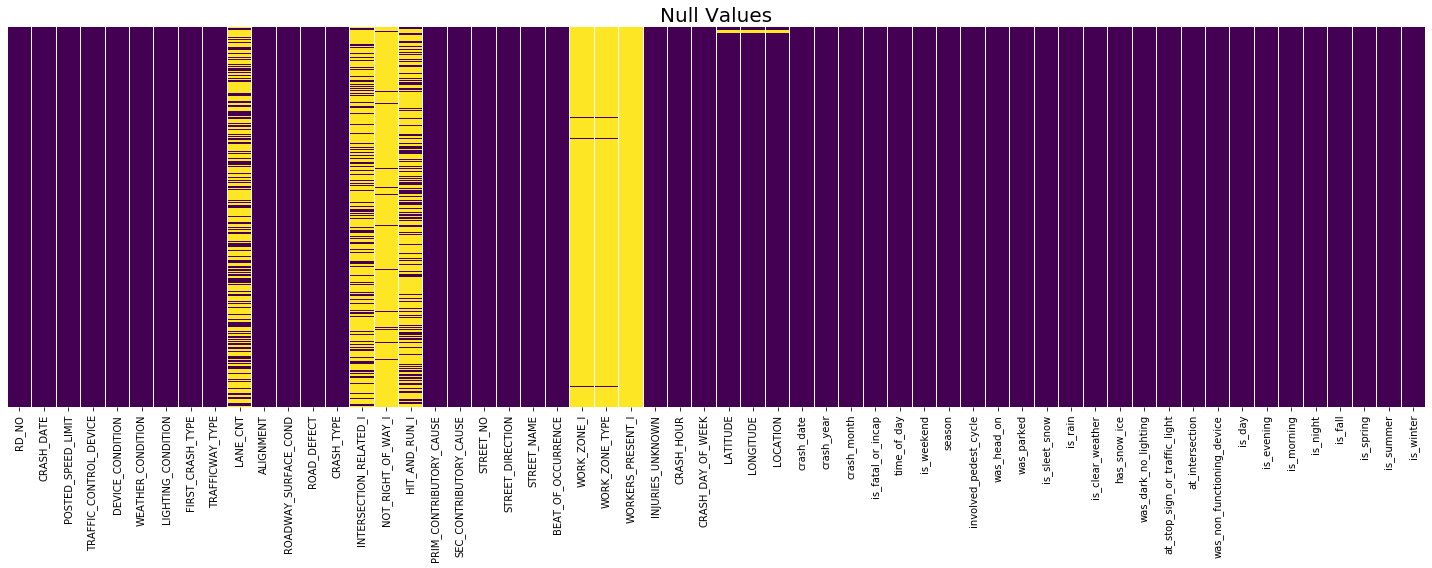

In [14]:
eda_feat_eng_utils.plot_null_val_heatmap(accidents, "Null Values", figsize=(20,8))

### Export Feature-Engineered Dataset

In [15]:
accidents.to_csv('data/accidents.csv')

---
## Unique Values for Features

In [12]:
for col in sorted(accidents['TRAFFIC_CONTROL_DEVICE'].unique()):
    print(col)

BICYCLE CROSSING SIGN
DELINEATORS
FLASHING CONTROL SIGNAL
LANE USE MARKING
NO CONTROLS
NO PASSING
OTHER
OTHER RAILROAD CROSSING
OTHER REG. SIGN
OTHER WARNING SIGN
PEDESTRIAN CROSSING SIGN
POLICE/FLAGMAN
RAILROAD CROSSING GATE
RR CROSSING SIGN
SCHOOL ZONE
STOP SIGN/FLASHER
TRAFFIC SIGNAL
UNKNOWN
YIELD


In [13]:
for col in sorted(accidents['DEVICE_CONDITION'].unique()):
    print(col)

FUNCTIONING IMPROPERLY
FUNCTIONING PROPERLY
MISSING
NO CONTROLS
NOT FUNCTIONING
OTHER
UNKNOWN
WORN REFLECTIVE MATERIAL


In [14]:
for col in sorted(accidents['WEATHER_CONDITION'].unique()):
    print(col)

BLOWING SAND, SOIL, DIRT
BLOWING SNOW
CLEAR
CLOUDY/OVERCAST
FOG/SMOKE/HAZE
FREEZING RAIN/DRIZZLE
OTHER
RAIN
SEVERE CROSS WIND GATE
SLEET/HAIL
SNOW
UNKNOWN


In [15]:
for col in sorted(accidents['LIGHTING_CONDITION'].unique()):
    print(col)

DARKNESS
DARKNESS, LIGHTED ROAD
DAWN
DAYLIGHT
DUSK
UNKNOWN


In [16]:
for col in sorted(accidents['FIRST_CRASH_TYPE'].unique()):
    print(col)

ANGLE
ANIMAL
FIXED OBJECT
HEAD ON
OTHER NONCOLLISION
OTHER OBJECT
OVERTURNED
PARKED MOTOR VEHICLE
PEDALCYCLIST
PEDESTRIAN
REAR END
REAR TO FRONT
REAR TO REAR
REAR TO SIDE
SIDESWIPE OPPOSITE DIRECTION
SIDESWIPE SAME DIRECTION
TRAIN
TURNING


In [16]:
for col in sorted(accidents['TRAFFICWAY_TYPE'].unique()):
    print(col)

ALLEY
CENTER TURN LANE
DIVIDED - W/MEDIAN (NOT RAISED)
DIVIDED - W/MEDIAN BARRIER
DRIVEWAY
FIVE POINT, OR MORE
FOUR WAY
L-INTERSECTION
NOT DIVIDED
NOT REPORTED
ONE-WAY
OTHER
PARKING LOT
RAMP
ROUNDABOUT
T-INTERSECTION
TRAFFIC ROUTE
UNKNOWN
UNKNOWN INTERSECTION TYPE
Y-INTERSECTION


In [17]:
for col in sorted(accidents['ALIGNMENT'].unique()):
    print(col)

CURVE ON GRADE
CURVE ON HILLCREST
CURVE, LEVEL
STRAIGHT AND LEVEL
STRAIGHT ON GRADE
STRAIGHT ON HILLCREST


In [18]:
for col in sorted(accidents['ROADWAY_SURFACE_COND'].unique()):
    print(col)

DRY
ICE
OTHER
SAND, MUD, DIRT
SNOW OR SLUSH
UNKNOWN
WET


In [19]:
for col in sorted(accidents['CRASH_TYPE'].unique()):
    print(col)

INJURY AND / OR TOW DUE TO CRASH
NO INJURY / DRIVE AWAY


In [20]:
for col in sorted(accidents['PRIM_CONTRIBUTORY_CAUSE'].unique()):
    print(col)

ANIMAL
BICYCLE ADVANCING LEGALLY ON RED LIGHT
CELL PHONE USE OTHER THAN TEXTING
DISREGARDING OTHER TRAFFIC SIGNS
DISREGARDING ROAD MARKINGS
DISREGARDING STOP SIGN
DISREGARDING TRAFFIC SIGNALS
DISREGARDING YIELD SIGN
DISTRACTION - FROM INSIDE VEHICLE
DISTRACTION - FROM OUTSIDE VEHICLE
DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)
DRIVING ON WRONG SIDE/WRONG WAY
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE
EQUIPMENT - VEHICLE CONDITION
EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST
EXCEEDING AUTHORIZED SPEED LIMIT
EXCEEDING SAFE SPEED FOR CONDITIONS
FAILING TO REDUCE SPEED TO AVOID CRASH
FAILING TO YIELD RIGHT-OF-WAY
FOLLOWING TOO CLOSELY
HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)
IMPROPER BACKING
IMPROPER LANE USAGE
IMPROPER OVERTAKING/PASSING
IMPROPER TURNING/NO SIGNAL
MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT
NOT APPLICABLE
OBSTRUCTED CROSSWALKS
OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER
PASSING STOPPED SCHOOL BUS
PHYS

In [ ]:
for col in sorted(accidents['SEC_CONTRIBUTORY_CAUSE'].unique()):
    print(col)

In [ ]:
for col in sorted(accidents['STREET_DIRECTION'].unique()):
    print(col)

In [ ]:

# for col in sorted(accidents['BEAT_OF_OCCURRENCE'].unique()):
#     print(col)

---
## EDA

Percent Resulting in Fatality or Incapacitation: 1.879%




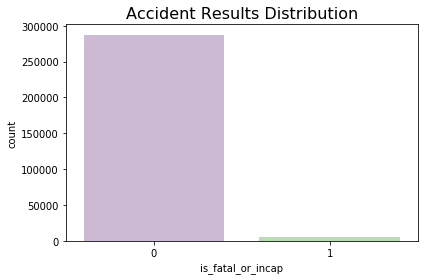

In [23]:
eda_feat_eng_utils.display_bar_plot(accidents, 'is_fatal_or_incap', 'Accident Results Distribution')

print('Percent Resulting in Fatality or Incapacitation: {0:.3%}'.format(sum(accidents['is_fatal_or_incap']) / len(accidents['is_fatal_or_incap'])))
print('\n')

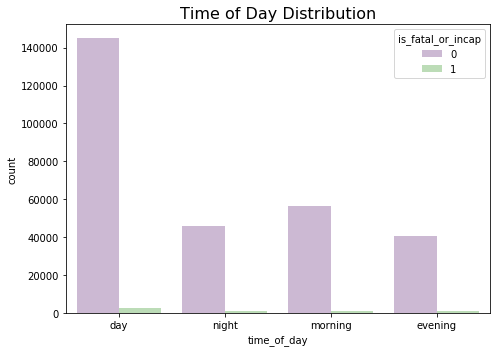

In [24]:
eda_feat_eng_utils.display_bar_plot(accidents, 'time_of_day', 'Time of Day Distribution', figsize=(7,5), hue='is_fatal_or_incap')

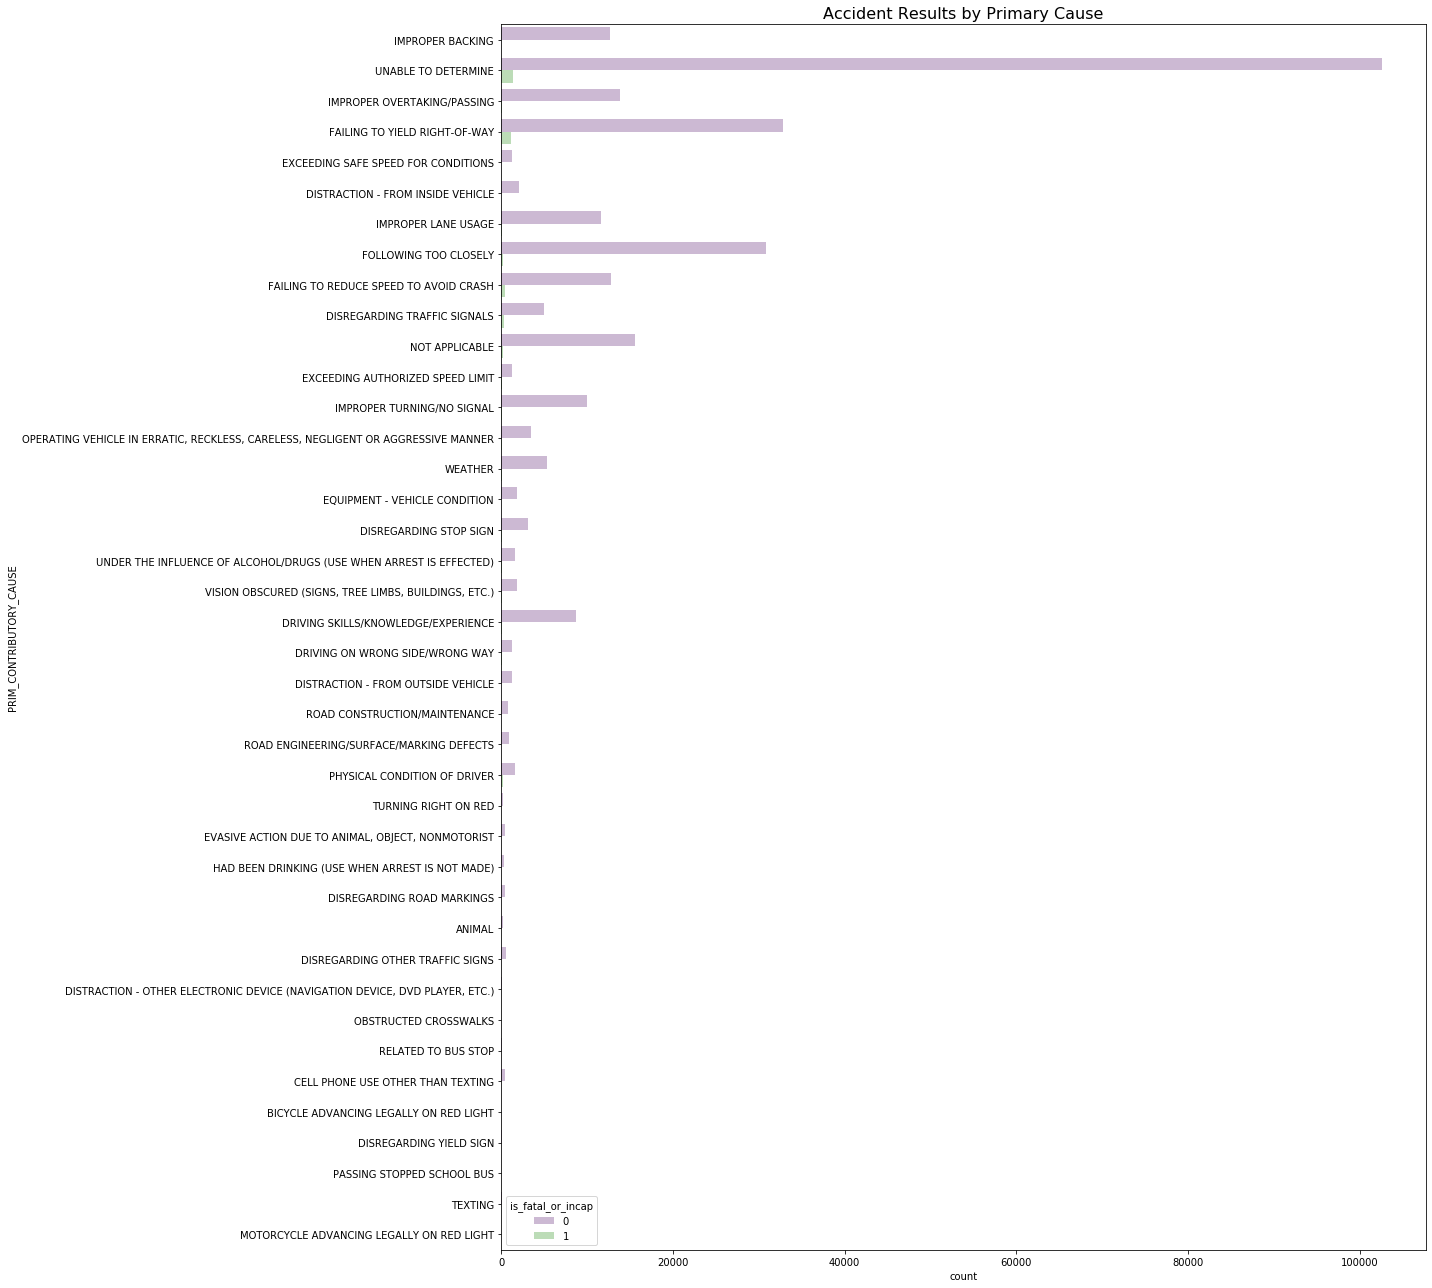

In [26]:
data=accidents
x='PRIM_CONTRIBUTORY_CAUSE'
title='Accident Results by Primary Cause' 
figsize=(20,18)
hue='is_fatal_or_incap'

fig, ax = plt.subplots(figsize=figsize)
sns.countplot(data=data,y=x, hue=hue, palette='PRGn', ax=ax, orient='v')
ax.set_title(title, fontsize=16)
fig.tight_layout();

In [ ]:
plot_density_distribution_by_class(accidents, 'is_fatal_or_incap', 'CRASH_HOUR', (12,5), 'Accident Results by Crash Hour', 0)

In [ ]:
# Sunday = 1
plot_density_distribution_by_class(accidents, 'is_fatal_or_incap', 'CRASH_DAY_OF_WEEK', (12,5), 'Accident Results by Crash Hour')

In [ ]:
df = accidents
class_col = 'is_fatal_or_incap'
feature_name = 'POSTED_SPEED_LIMIT'
figsize = (10,5)
title='Distribution of POSTED Speed Limit'
bandwidth=1

fatal_arr = df[df[class_col] == 1][feature_name].values
not_fatal_arr = df[df[class_col] == 0][feature_name].values


fig, ax = plt.subplots(figsize=figsize)
ax = sns.kdeplot(fatal_arr, shade=True, color="b", bw=bandwidth, label = 'Fatal / Incapacitated')
ax = sns.kdeplot(not_fatal_arr, shade=True, color="r", bw=bandwidth, label = 'Not Severe')
ax.legend()
ax.set_title(title, fontsize=18)
fig.tight_layout();

In [ ]:
plot_density_distribution_by_class(accidents, 'is_fatal_or_incap', 'crash_month', (12,5), 'Accident Results by Crash Hour')

In [ ]:
display_bar_plot(accidents, 'has_snow_ice', 'Accident Results by Road Condition', figsize=(7,5), hue='is_fatal_or_incap')

In [ ]:
display_bar_plot(accidents, 'at_intersection', 'Accidents at Intersection', figsize=(7,5), hue='is_fatal_or_incap')

In [ ]:
display_bar_plot(accidents, 'WEATHER_CONDITION', 'Accidents at Intersection', figsize=(20,6), hue='is_fatal_or_incap')

### Chicago Map

In [23]:
chicago_map = gpd.read_file('data/geo_export_43ec9622-8645-42eb-b42b-cdd7d8603939.shp')

In [33]:
geography = accidents[['is_fatal_or_incap', 'LATITUDE', 'LONGITUDE']].copy()
geometry = [Point(xy) for xy in zip(geography['LATITUDE'], geography['LONGITUDE'])]

In [35]:
geo_df = gpd.GeoDataFrame(geography, geometry=geometry)
geo_df.head()

,is_fatal_or_incap,LATITUDE,LONGITUDE,geometry
0,0,41.919664,-87.773288,POINT (41.91966 -87.77329)
5,0,41.741804,-87.740954,POINT (41.74180 -87.74095)
6,0,41.953647,-87.732082,POINT (41.95365 -87.73208)
10,0,41.903825,-87.643286,POINT (41.90383 -87.64329)
11,0,41.794779,-87.623828,POINT (41.79478 -87.62383)


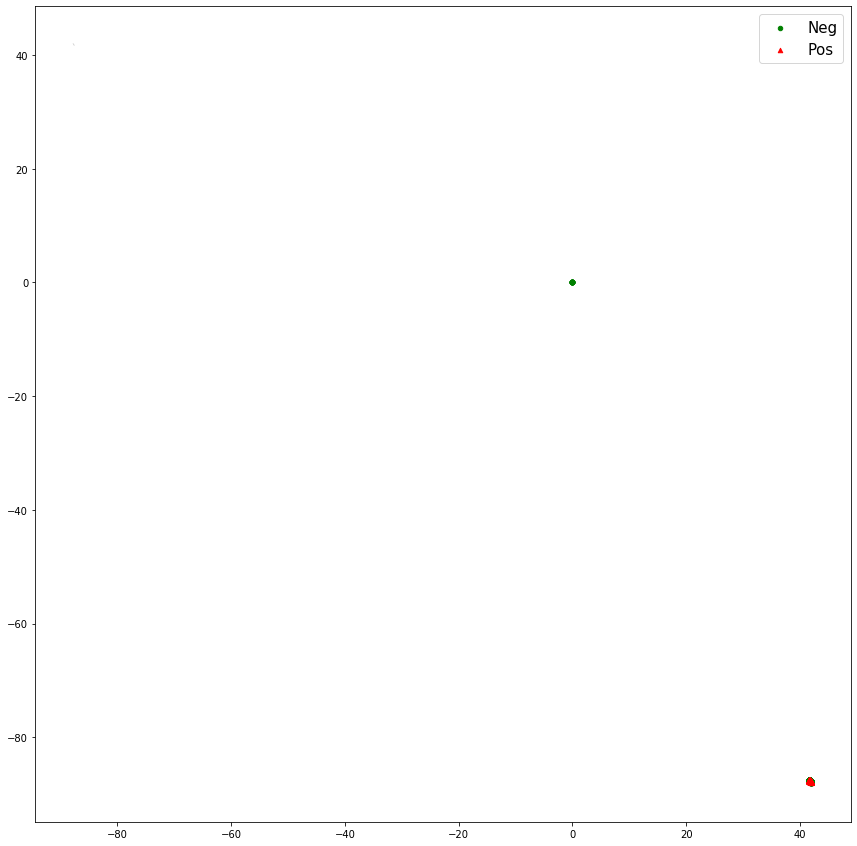

In [37]:
fig, ax = plt.subplots(figsize=(15,15))

chicago_map.plot(ax = ax, color='grey', alpha=0.4)
geo_df[geo_df['is_fatal_or_incap'] == 0].plot(ax=ax, markersize=20, color='green', marker='o', label='Neg')
geo_df[geo_df['is_fatal_or_incap'] == 1].plot(ax=ax, markersize=20, color='red', marker='^', label='Pos')
plt.legend(prop={'size':15});

In [38]:
geo_df

,is_fatal_or_incap,LATITUDE,LONGITUDE,geometry
0,0,41.919664,-87.773288,POINT (41.91966 -87.77329)
5,0,41.741804,-87.740954,POINT (41.74180 -87.74095)
6,0,41.953647,-87.732082,POINT (41.95365 -87.73208)
10,0,41.903825,-87.643286,POINT (41.90383 -87.64329)
11,0,41.794779,-87.623828,POINT (41.79478 -87.62383)
...,...,...,...,...
472790,0,41.975810,-87.687248,POINT (41.97581 -87.68725)
472791,0,41.929591,-87.639941,POINT (41.92959 -87.63994)
472794,0,41.940241,-87.639639,POINT (41.94024 -87.63964)
472795,0,41.910941,-87.648419,POINT (41.91094 -87.64842)
